In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torchvision import transforms, datasets
from tqdm.notebook import tqdm

In [2]:
np.random.seed(42)
torch.manual_seed(42)

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
transform = transforms.Compose(
    [transforms.ToTensor(), 
     transforms.Normalize((0.0,), (1.0,))])

dataset = datasets.MNIST(root = './data', train=True, transform = transform, download=True)

train_size = int(0.9 * len(dataset))
test_size = len(dataset) - train_size

train_set, val_set = torch.utils.data.random_split(dataset, [train_size, test_size])
test_set = datasets.MNIST(root = './data', train=False, transform = transform, download=True)

In [5]:
train_batch_size = 16

train_loader = torch.utils.data.DataLoader(train_set,batch_size=train_batch_size,shuffle=True)
val_loader = torch.utils.data.DataLoader(val_set,batch_size=train_batch_size,shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set,batch_size=1,shuffle=True)

In [6]:
class SampleNet(nn.Module):
    def __init__(self):
        super(SampleNet, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=20, kernel_size=5, stride=1, padding=0)
        self.conv2 = nn.Conv2d(in_channels=20, out_channels=50, kernel_size=5, stride=1, padding=0)
        self.dropout1 = nn.Dropout2d(0.25)
        self.dropout2 = nn.Dropout2d(0.5)
        self.fc1 = nn.Linear(50 * 4 * 4, 500)
        self.fc2 = nn.Linear(500, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), (2, 2)))
        x = F.relu(F.max_pool2d(self.conv2(x), (2, 2)))
        x = self.dropout1(x)
        x = x.view(-1, self.n_feat(x))
        x = F.relu(self.fc1(x))
        x = self.dropout2(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output

    def n_feat(self, x):
        size = x.size()[1:]
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

In [7]:
model = SampleNet()
model = model.to(device)

sample №4426 has a label "9"
sample №5578 has a label "8"
sample №8322 has a label "9"
sample №1685 has a label "6"
sample №769 has a label "6"
sample №6949 has a label "2"
sample №2433 has a label "2"


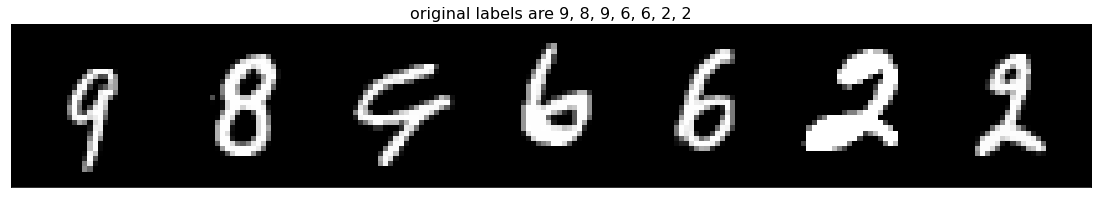

In [10]:
class_names = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
n_imgs = 7

def imshow(input, title):
    fig = plt.figure(figsize=(n_imgs * 3, 3))
    input = input.numpy().transpose((1, 2, 0))
    plt.imshow(input)
    plt.xticks([], [])
    plt.yticks([], [])
    plt.title(title, fontsize=16)

imgs, classes = [], []
n_samples = np.random.randint(0, len(test_set), size=n_imgs)

for i in n_samples:
    imgs.append(test_set[i][0])
    classes.append(test_set[i][1])

out = torchvision.utils.make_grid(imgs[:n_imgs])
imshow(out, title='original labels are {}'.format(', '.join([str(cls) for cls in classes])))

for i, label in enumerate(classes[:n_imgs]):
    print(f'sample №{n_samples[i]} has a label "{class_names[label]}"')

## Training

In [11]:
optimizer = optim.Adam(model.parameters(),lr=0.0001)
criterion = nn.NLLLoss()

In [12]:
def train(model, device, train_loader, val_loader, epochs):
  data_loader = {'train':train_loader,'val':val_loader}
  data_sizes = {'train':len(train_set),'val':len(val_set)}
  train_loss,val_loss = [],[]

  for epoch in range(epochs):
    loss_per_epoch,val_loss_per_epoch=0,0
    for phase in ('train','val'):
      for i,data in tqdm(enumerate(data_loader[phase]), total=int(data_sizes[phase]/train_batch_size)):

        input,label  = data[0].to(device),data[1].to(device)
        output = model(input)
        loss = criterion(output,label)

        if phase == 'train':
          optimizer.zero_grad()
          loss.backward()
          optimizer.step()
          loss_per_epoch+=loss.item()

        else:
          val_loss_per_epoch+=loss.item()

    print(f"Epoch {epoch+1} | Train Loss: {loss_per_epoch/len(train_loader)} | Validation Loss: {val_loss_per_epoch/len(val_loader)}")

    train_loss.append(loss_per_epoch/len(train_loader))
    val_loss.append(val_loss_per_epoch/len(val_loader))
  return train_loss,val_loss

In [13]:
n_epochs = 10
loss, val_loss = train(model, device, train_loader, val_loader, n_epochs)

  0%|          | 0/3375 [00:00<?, ?it/s]

  0%|          | 0/375 [00:00<?, ?it/s]

Epoch 1 | Train Loss: 0.3810196515830855 | Validation Loss: 0.15133826607838274


  0%|          | 0/3375 [00:00<?, ?it/s]

  0%|          | 0/375 [00:00<?, ?it/s]

Epoch 2 | Train Loss: 0.118851827652711 | Validation Loss: 0.0999803037631015


  0%|          | 0/3375 [00:00<?, ?it/s]

  0%|          | 0/375 [00:00<?, ?it/s]

Epoch 3 | Train Loss: 0.085712078410951 | Validation Loss: 0.08379040268730993


  0%|          | 0/3375 [00:00<?, ?it/s]

  0%|          | 0/375 [00:00<?, ?it/s]

Epoch 4 | Train Loss: 0.06840510429387602 | Validation Loss: 0.07576844004324326


  0%|          | 0/3375 [00:00<?, ?it/s]

  0%|          | 0/375 [00:00<?, ?it/s]

Epoch 5 | Train Loss: 0.05763319015813802 | Validation Loss: 0.062470119350628614


  0%|          | 0/3375 [00:00<?, ?it/s]

  0%|          | 0/375 [00:00<?, ?it/s]

Epoch 6 | Train Loss: 0.050402799932460766 | Validation Loss: 0.05640459181795207


  0%|          | 0/3375 [00:00<?, ?it/s]

  0%|          | 0/375 [00:00<?, ?it/s]

Epoch 7 | Train Loss: 0.04471272128003356 | Validation Loss: 0.059919815944119666


  0%|          | 0/3375 [00:00<?, ?it/s]

  0%|          | 0/375 [00:00<?, ?it/s]

Epoch 8 | Train Loss: 0.04040509403985656 | Validation Loss: 0.05519634796391862


  0%|          | 0/3375 [00:00<?, ?it/s]

  0%|          | 0/375 [00:00<?, ?it/s]

Epoch 9 | Train Loss: 0.035037359104713825 | Validation Loss: 0.052596613410743884


  0%|          | 0/3375 [00:00<?, ?it/s]

  0%|          | 0/375 [00:00<?, ?it/s]

Epoch 10 | Train Loss: 0.033217022288699 | Validation Loss: 0.0467751512475661


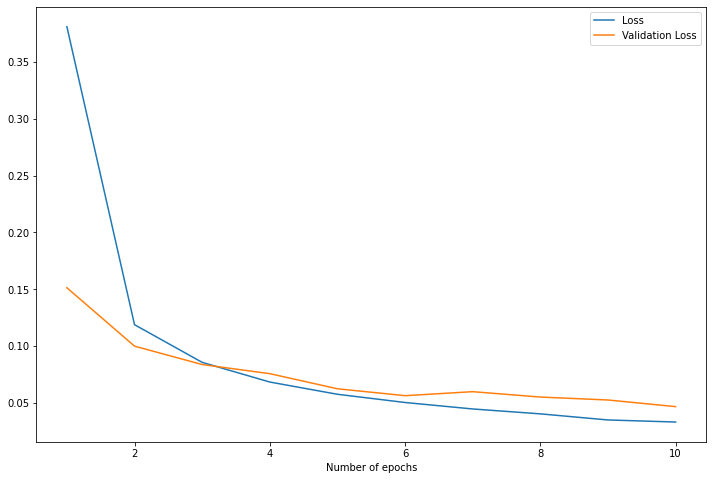

In [14]:
plt.figure(figsize=(12, 8))
plt.plot(np.arange(1,n_epochs+1), loss, label="Loss")
plt.plot(np.arange(1,n_epochs+1), val_loss, label="Validation Loss")
plt.xlabel("Number of epochs")
plt.legend()
plt.show()

In [25]:
def ifgsm_atk(x, eps, d_grad, n_iter = 10):

  adv_x = x.clone()
  for _ in range(n_iter):
    adv_x = adv_x + (eps/n_iter)*d_grad.sign()
    adv_x = torch.clip(adv_x, 0, 1)

    if torch.norm((adv_x-x), p=float('inf')) > eps:
      break

  return adv_x

In [26]:
def attack(model, device, test_loader, epsilon, n_results = 7):
    correct = 0
    adv_results = []
    for sample, target in test_loader:
        sample, target = sample.to(device), target.to(device)
        sample.requires_grad = True

        # смотрим на изначальное предсказание модели
        # и если оно правильное - будем его атаковать
        
        orig_prob = model(sample)
        orig_pred = orig_prob.max(1, keepdim=True)[1]


        if orig_pred.item() != target.item():
            continue
        
        loss = F.nll_loss(orig_prob, target)
        model.zero_grad()
        loss.backward()
        d_grad = sample.grad.data
        
        new_sample = ifgsm_atk(sample, epsilon, d_grad)
        final_prob = model(new_sample)
        final_pred = final_prob.max(1, keepdim=True)[1]

        if final_pred.item() == target.item():
            correct += 1

            # т.к. эпсилон=0 тоже рассматриваем, для него тоже нужно будет вывести результаты
            # (хоть изменений в предсказании и не будет)

            if (epsilon == 0) and (len(adv_results) < n_results):
                adv_ex = new_sample.squeeze().detach().cpu().numpy()
                adv_results.append(
                    (orig_pred.item(), final_pred.item(), adv_ex))
        else:
            if len(adv_results) < n_results:
                adv_ex = new_sample.squeeze().detach().cpu().numpy()
                adv_results.append(
                    (orig_pred.item(), final_pred.item(), adv_ex))

    final_acc = correct/float(len(test_loader))
    print(f"Epsilon: {epsilon}\t|  Test Accuracy = {final_acc}")

    return final_acc, adv_results

In [27]:
def show_acc(all_eps, model, device, loader):
    accuracies, results = [], []

    for eps in tqdm(epsilons):
        acc, ex = attack(model, device, loader, eps)
        accuracies.append(acc)
        results.append(ex)

    plt.figure(figsize=(12,8))
    plt.plot(epsilons, accuracies)
    plt.xlabel("Epsilon")
    plt.ylabel("Accuracy")
    plt.show()

    return accuracies, results

  0%|          | 0/9 [00:00<?, ?it/s]

Epsilon: 0	|  Test Accuracy = 0.9831
Epsilon: 0.005	|  Test Accuracy = 0.9823
Epsilon: 0.01	|  Test Accuracy = 0.9792
Epsilon: 0.02	|  Test Accuracy = 0.9771
Epsilon: 0.05	|  Test Accuracy = 0.9535
Epsilon: 0.1	|  Test Accuracy = 0.8644
Epsilon: 0.2	|  Test Accuracy = 0.4435
Epsilon: 0.3	|  Test Accuracy = 0.0972
Epsilon: 0.4	|  Test Accuracy = 0.0221


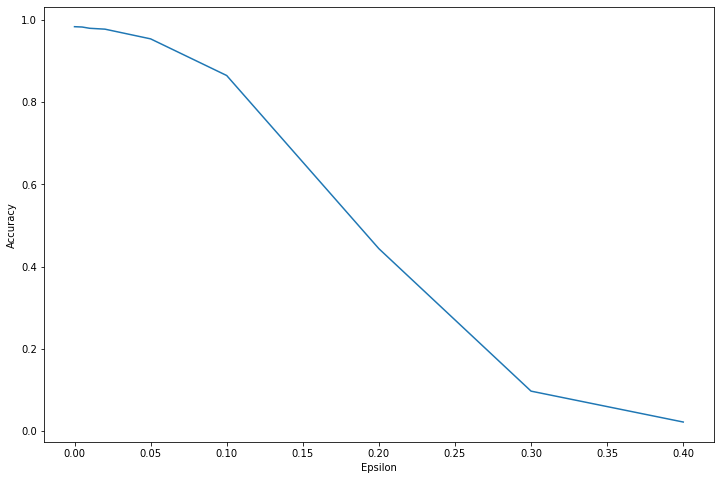

In [28]:
epsilons = [0, 0.005, 0.01, 0.02, 0.05, 0.1, 0.2, 0.3, 0.4]
accuracies, results = show_acc(epsilons, model, device, test_loader)

In [31]:
def show_compare(all_eps, results):
    cnt = 0
    plt.figure(figsize=(1.3*len(all_eps), 1.7 * len(all_eps)))

    for i in tqdm(range(len(all_eps))):
        for j in range(len(results[i])):
            cnt += 1
            plt.subplot(len(all_eps),len(results[0]),cnt)
            plt.xticks([], [])
            plt.yticks([], [])

            if j == 0:
                plt.ylabel(f"Eps: {all_eps[i]}", fontsize=10)

            orig, adv, ex = results[i][j]
            plt.title(f"old label: {orig}\n new label: {adv}", fontsize=14)
            plt.imshow(ex, cmap="gray")
    plt.tight_layout()
    plt.show()

  0%|          | 0/9 [00:00<?, ?it/s]

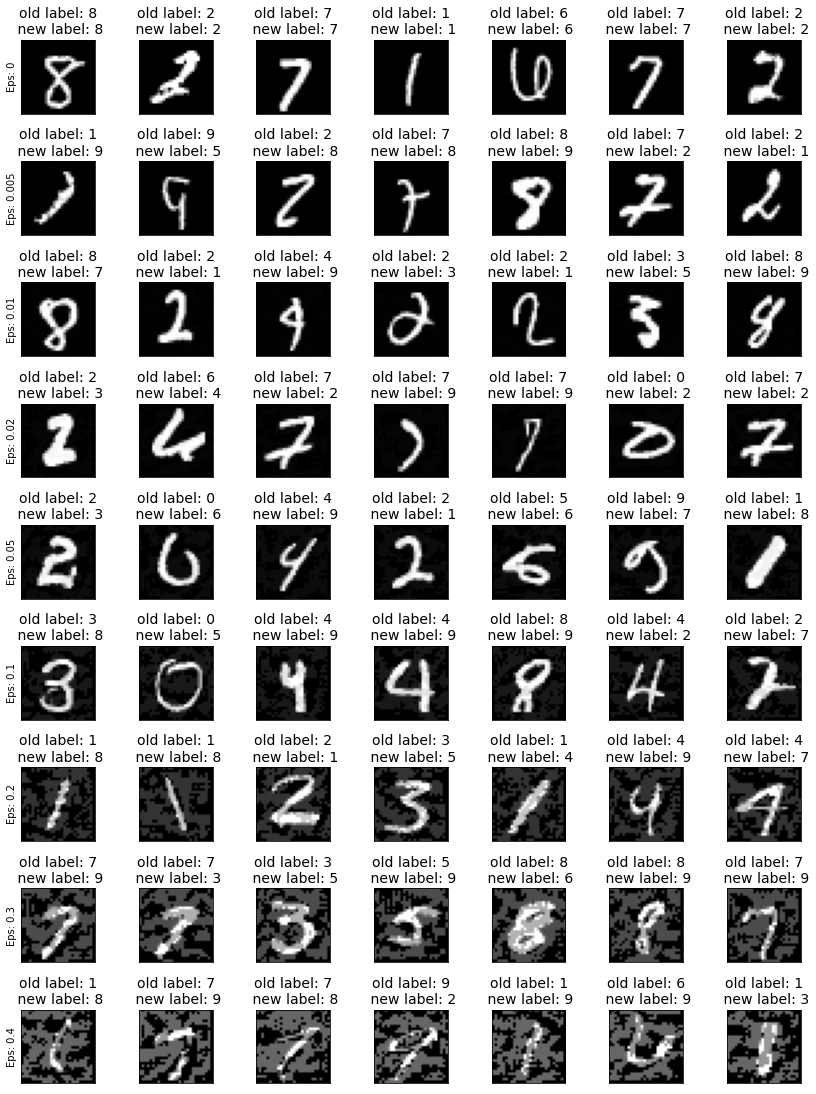

In [32]:
show_compare(epsilons, results)